<center>

EcoCommons GitHub Notebooks ![EcoCommons](https://www.ecocommons.org.au)
    
</center>


# EcoCommons Notebook 
## Species Distribution Model
### Genralised Linear Model GLM 


---
Author details:     
Contact details: comms@ecocommons.org.au  
Copyright statement: This script is the product of the EcoCommons platform.   
                     Please refer to the EcoCommons website for more details:   
                     <https://www.ecocommons.org.au/>  
Date: August 2024  

---

#### Script and data info: 

This notebook provides an example of how to run a simple version SDM 

In the near future, this material may form part of comprehensive support materials available to EcoCommons users.
 
If you have any corrections or suggestions to improve the effeciengy, please [contact the EcoCommons](mailto:comms@ecocommons.org.au) support and communications team.

In [2]:
#packages for the analysis

library(dismo)
library(dplyr)
library(ggplot2)
library(raster)




Loading required package: raster

Loading required package: sp


Attaching package: 'dplyr'


The following objects are masked from 'package:raster':

    intersect, select, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
setwd("/Users/qcifecocommons/Documents/RDIR/wd4liteSDM/sdm_data")
getwd()


[1] "/Users/qcifecocommons/Documents/RDIR/wd4liteSDM/sdm_data"

In [5]:
#read occurance data
tree_kangaroo_data <-read.csv("Tree_kangaroo.csv")
#check data class
sapply(tree_kangaroo_data, class)
#change data class to numeric
tree_kangaroo_data <- tree_kangaroo_data %>% mutate(across(where(is.character), as.numeric))
#check again
sapply(tree_kangaroo_data, class)
#assign CRS



species         lat         lon     present 
"character"   "numeric"   "numeric"   "integer"

Warning message:
"There was 1 warning in `mutate()`.
i In argument: `across(where(is.character), as.numeric)`.
Caused by warning:
! NAs introduced by coercion"


species       lat       lon   present 
"numeric" "numeric" "numeric" "integer"

In [6]:
file.exists("env_forecast.gri")
env_data_current <-stack("env_current.grd")
env_data_forecast <-stack("env_forecast.gri")

[1] TRUE

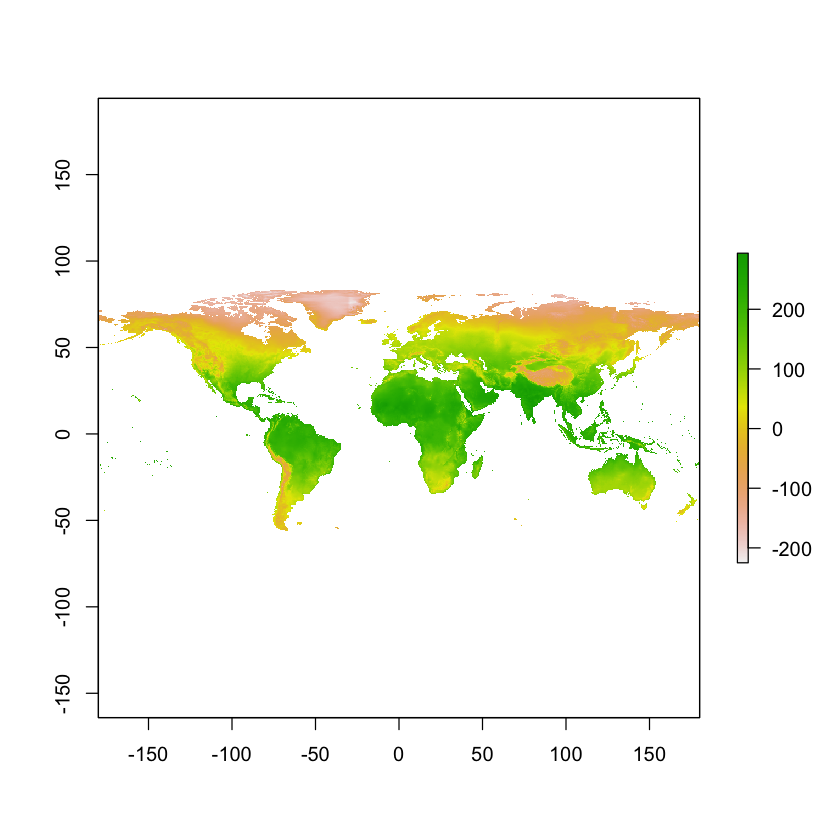

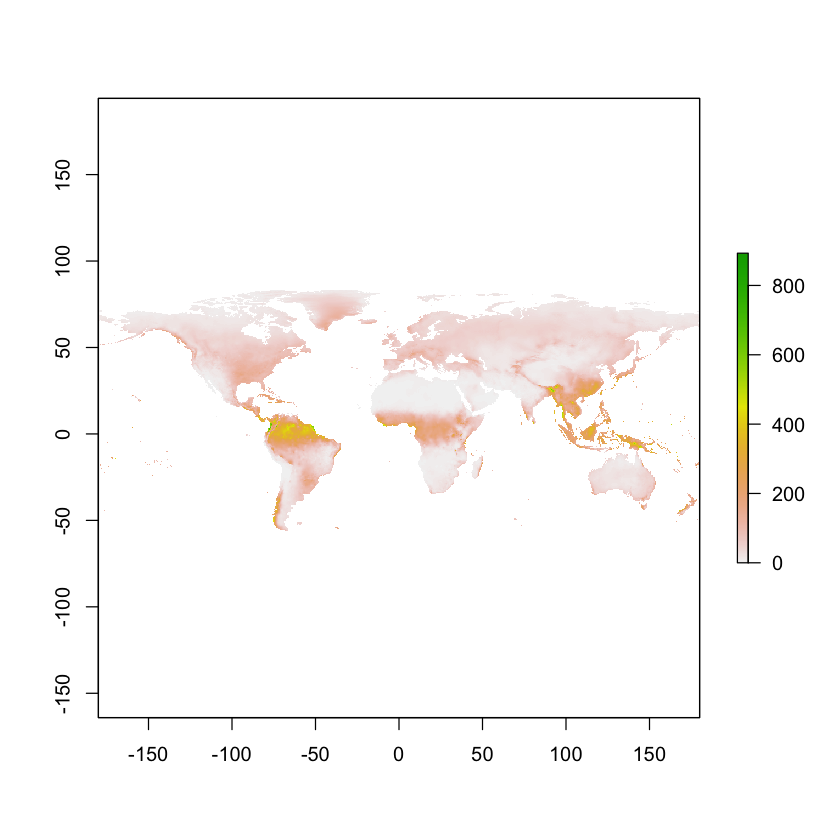

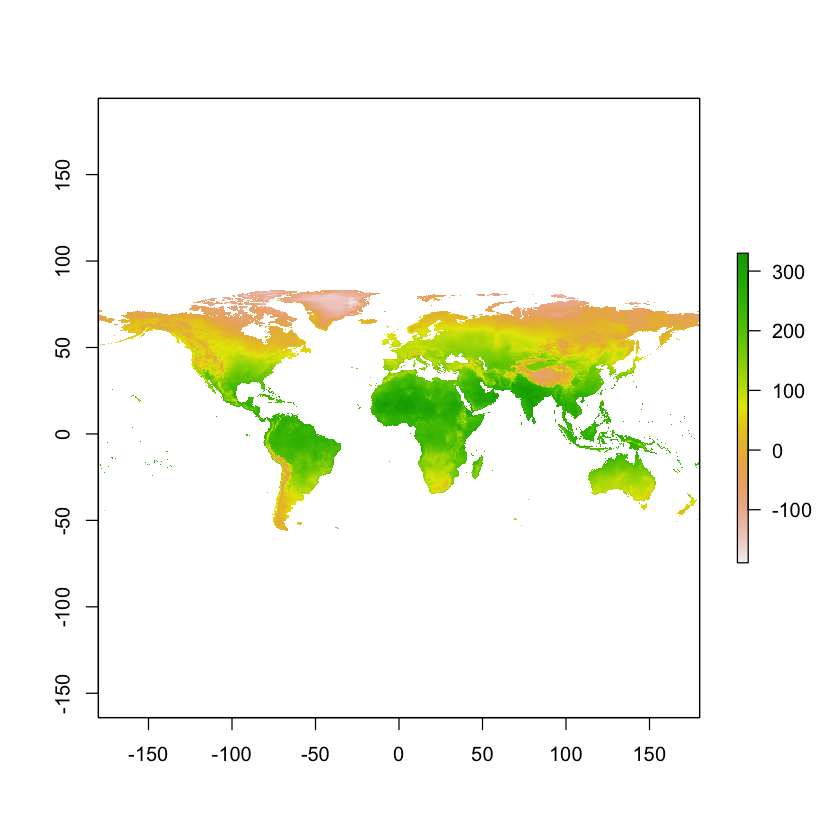

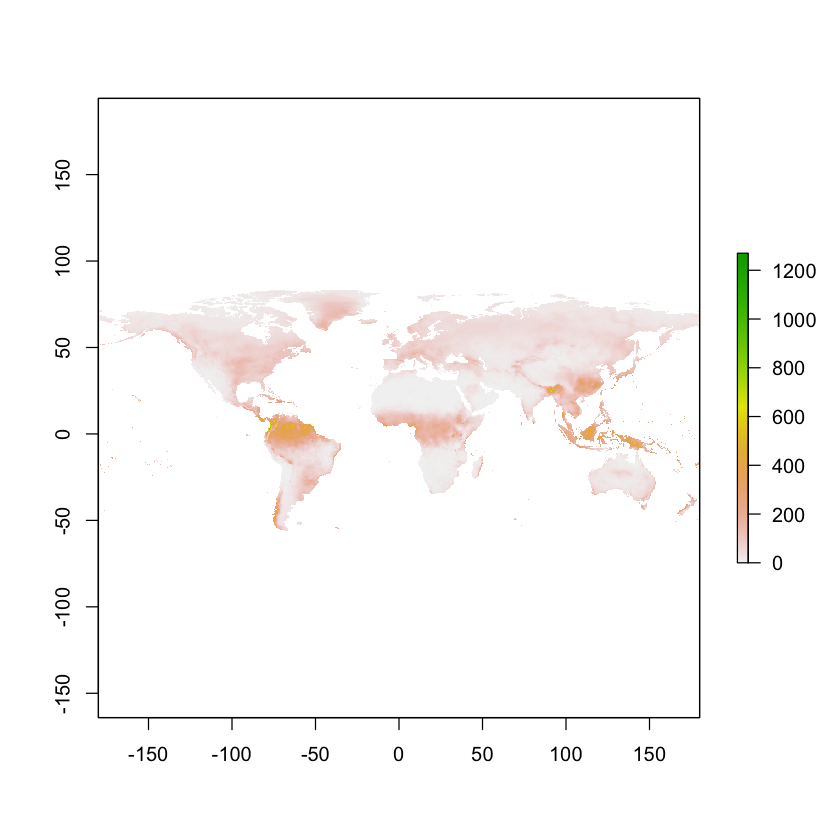

In [7]:
plot(env_data_current$tmin)
plot(env_data_current$precip)
plot(env_data_forecast$tmin)
plot(env_data_forecast$precip)

In [1]:
tk_locations <- select(tree_kangaroo_data,lon,lat)
tk_env <-extract(env_data_current,tk_locations)
tree_kangaroo_data <- cbind(tree_kangaroo_data, tk_env)



ERROR: Error in select(tree_kangaroo_data, lon, lat): could not find function "select"


In [9]:
# Check CRS

crs(env_data_current)
crs(tk_locations)

Coordinate Reference System:
Deprecated Proj.4 representation:
 +proj=longlat +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs 
WKT2 2019 representation:
BOUNDCRS[
    SOURCECRS[
        GEOGCRS["unknown",
            DATUM["World Geodetic System 1984",
                ELLIPSOID["WGS 84",6378137,298.257223563,
                    LENGTHUNIT["metre",1]],
                ID["EPSG",6326]],
            PRIMEM["Greenwich",0,
                ANGLEUNIT["degree",0.0174532925199433],
                ID["EPSG",8901]],
            CS[ellipsoidal,2],
                AXIS["longitude",east,
                    ORDER[1],
                    ANGLEUNIT["degree",0.0174532925199433,
                        ID["EPSG",9122]]],
                AXIS["latitude",north,
                    ORDER[2],
                    ANGLEUNIT["degree",0.0174532925199433,
                        ID["EPSG",9122]]]]],
    TARGETCRS[
        GEOGCRS["WGS 84",
            DATUM["World Geodetic System 1984",
                ELLIPSOID[

[1] NA

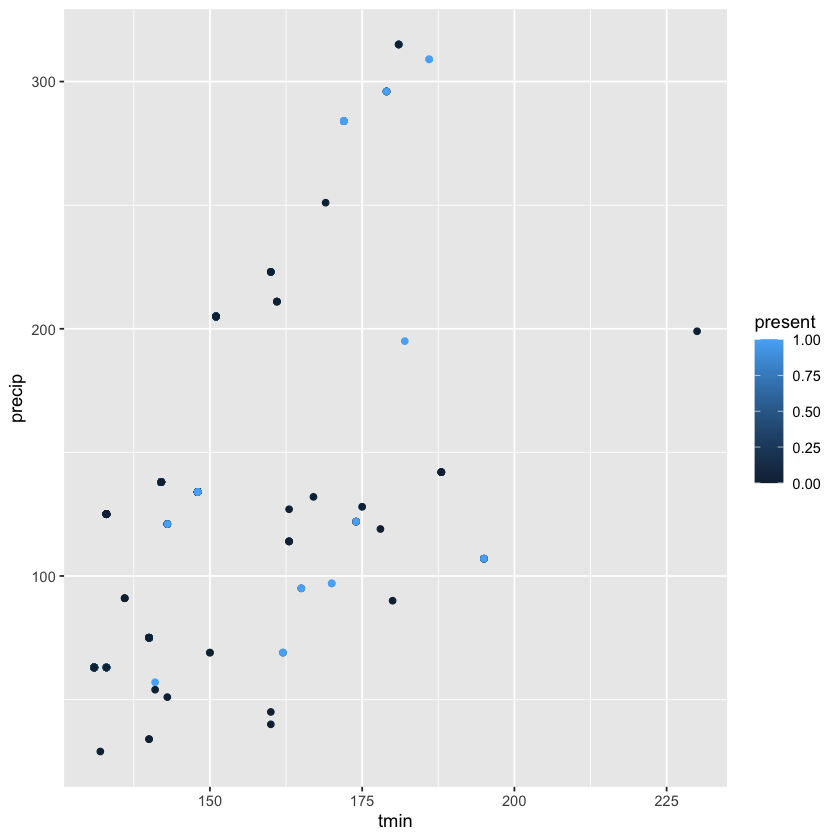

In [10]:
ggplot(tree_kangaroo_data, 
       mapping = aes(x =tmin,y = precip, color = present)) +
  geom_point()

In [11]:
#GLM
#multivariate ligistic regression
#Occurance on X & envir on Y
#Probability low or high for multiple variables

logistic_regr_model <- glm(present ~ tmin + precip,
                           family = binomial(link = "logit"),
                           data = tree_kangaroo_data)
summary(logistic_regr_model)


Call:
glm(formula = present ~ tmin + precip, family = binomial(link = "logit"), 
    data = tree_kangaroo_data)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -1.925655   1.099357  -1.752   0.0798 .
tmin         0.006446   0.008475   0.761   0.4469  
precip       0.001007   0.001951   0.516   0.6058  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 864.30  on 707  degrees of freedom
Residual deviance: 862.23  on 705  degrees of freedom
AIC: 868.23

Number of Fisher Scoring iterations: 4


# Model evaluation

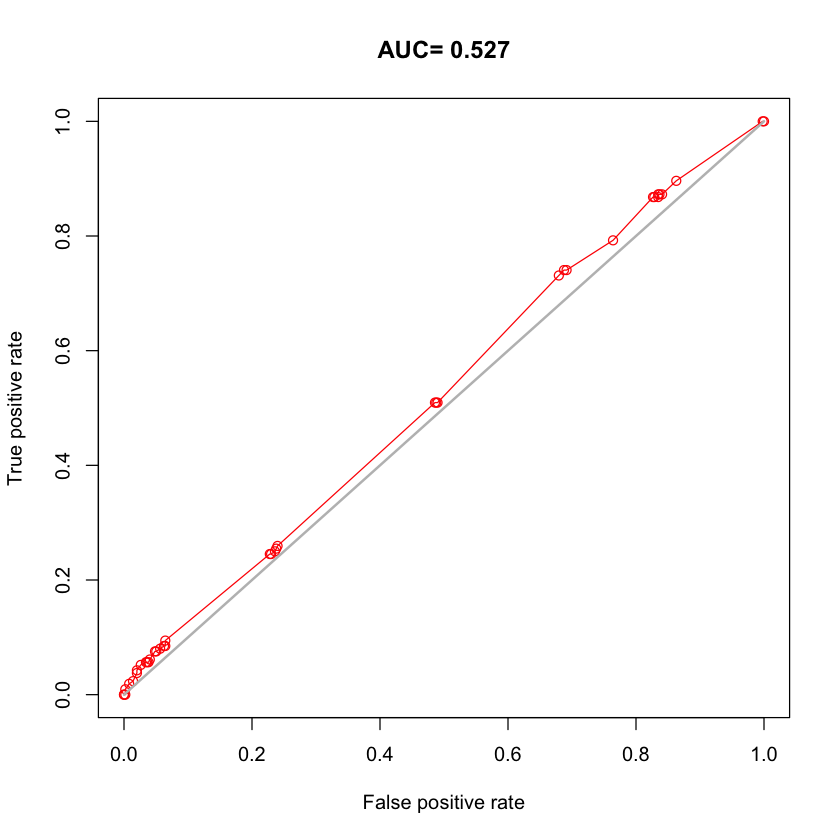

In [12]:
presence_data <-filter(tree_kangaroo_data,present ==1)
absence_data <-filter(tree_kangaroo_data,present ==0)

evaluation = evaluate(presence_data,absence_data,logistic_regr_model)
plot(evaluation,"ROC")

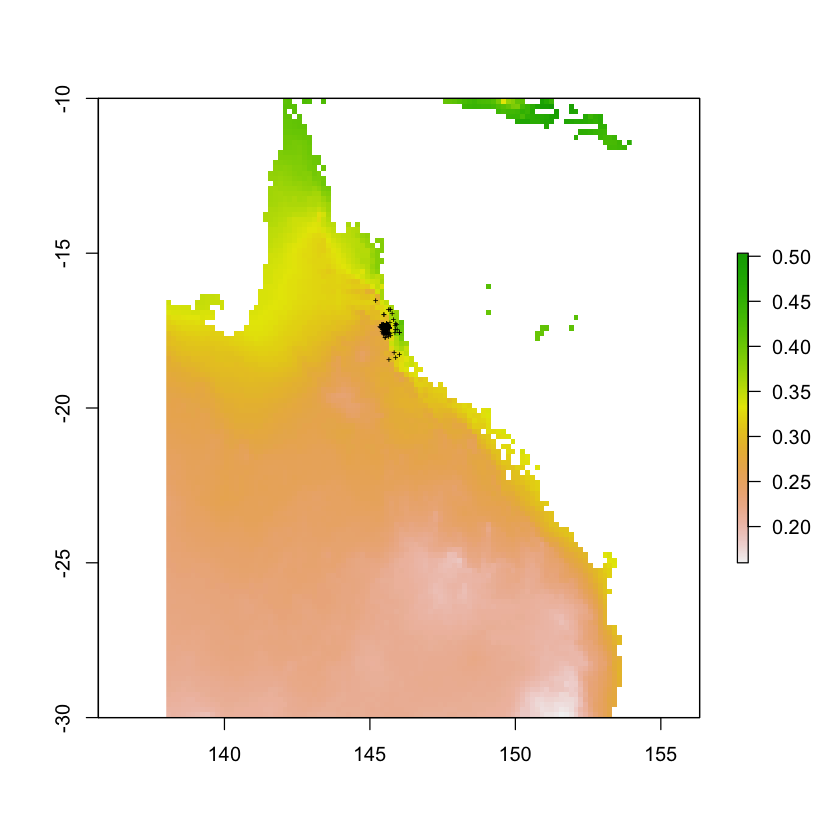

In [13]:
#absence from large scales can be problematic


predictions = predict(env_data_current,
                      logistic_regr_model,
                      type = "response") 
plot(predictions, ext = extent(138, 154, -30, -10))

points(presence_data[c("lon","lat")],pch ="+", cex = 0.5)



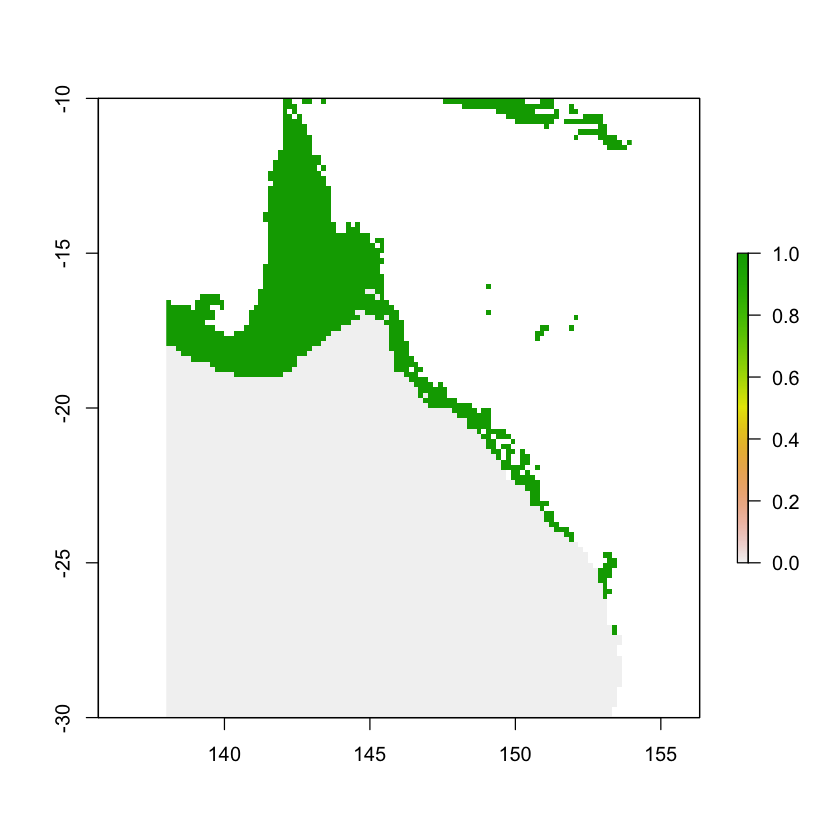

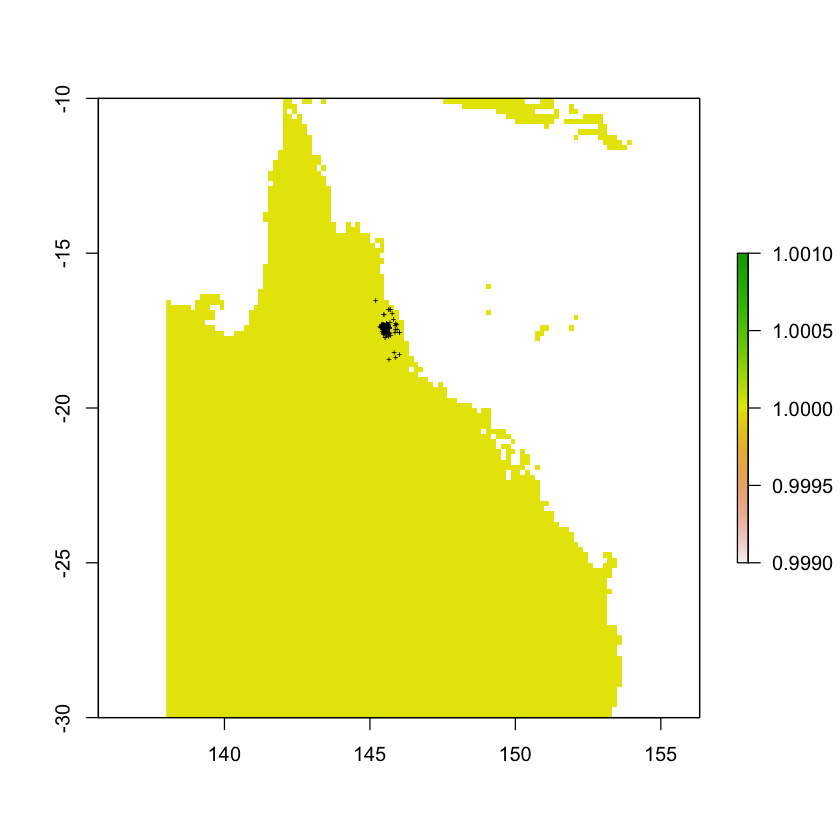

In [14]:
#40% threshold
plot(predictions>0.3, ext =extent(138, 154, -30, -10))
# Calculate the threshold
tr <- threshold(evaluation, stat = "prevalence")
# Plot the predictions with the specified threshold and extent
plot(predictions > tr, ext = extent(138, 154, -30, -10))
points(presence_data[c("lon", "lat")], pch = "+", cex = 0.5)


In [15]:
str(env_data_forecast)
summary(env_data_forecast)
summary(env_data_current)
model_vars <- names(coef(logistic_regr_model))
missing_vars <- setdiff(model_vars, names(env_data_forecast))

if (length(missing_vars) > 0) {
  print(paste("Missing variables in env_data_forecast:", paste(missing_vars, collapse = ", ")))
}


Formal class 'RasterStack' [package "raster"] with 12 slots
  ..@ filename: chr ""
  ..@ layers  :List of 2
  .. ..$ :Formal class 'RasterLayer' [package "raster"] with 13 slots
  .. .. .. ..@ file    :Formal class '.RasterFile' [package "raster"] with 13 slots
  .. .. .. .. .. ..@ name        : chr "/Users/qcifecocommons/Documents/RDIR/wd4liteSDM/sdm_data/env_forecast.grd"
  .. .. .. .. .. ..@ datanotation: chr "FLT4S"
  .. .. .. .. .. ..@ byteorder   : Named chr "little"
  .. .. .. .. .. .. ..- attr(*, "names")= chr "value"
  .. .. .. .. .. ..@ nodatavalue : num -3.4e+38
  .. .. .. .. .. ..@ NAchanged   : logi FALSE
  .. .. .. .. .. ..@ nbands      : int 2
  .. .. .. .. .. ..@ bandorder   : Named chr "BIL"
  .. .. .. .. .. .. ..- attr(*, "names")= chr "value"
  .. .. .. .. .. ..@ offset      : int 0
  .. .. .. .. .. ..@ toptobottom : logi TRUE
  .. .. .. .. .. ..@ blockrows   : int 0
  .. .. .. .. .. ..@ blockcols   : int 0
  .. .. .. .. .. ..@ driver      : chr "raster"
  .. .. .. .

Warning message in .local(object, ...):
"summary is an estimate based on a sample of 1e+05 cells (5.14% of all cells)
"


,tmin,precip
Min.,-187,0
1st Qu.,12,15
Median,100,36
3rd Qu.,199,69
Max.,330,1039
NA's,1356387,1356387


Warning message in .local(object, ...):
"summary is an estimate based on a sample of 1e+05 cells (5.14% of all cells)
"


,tmin,precip
Min.,-223,0
1st Qu.,-19,14
Median,72,34
3rd Qu.,170,67
Max.,289,879
NA's,1356387,1356387


[1] "Missing variables in env_data_forecast: (Intercept)"


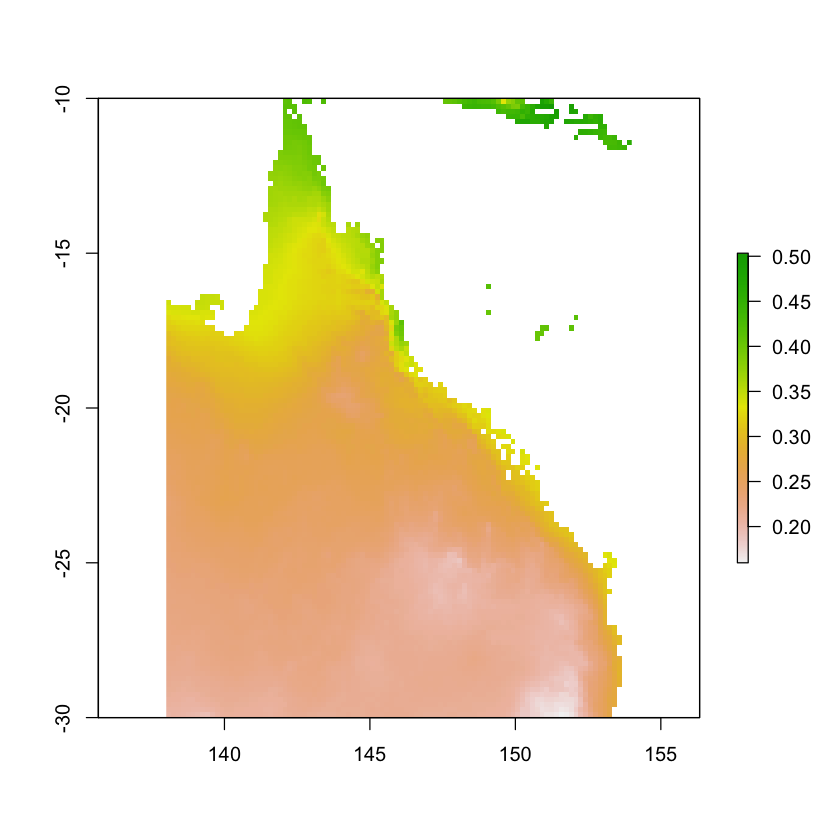

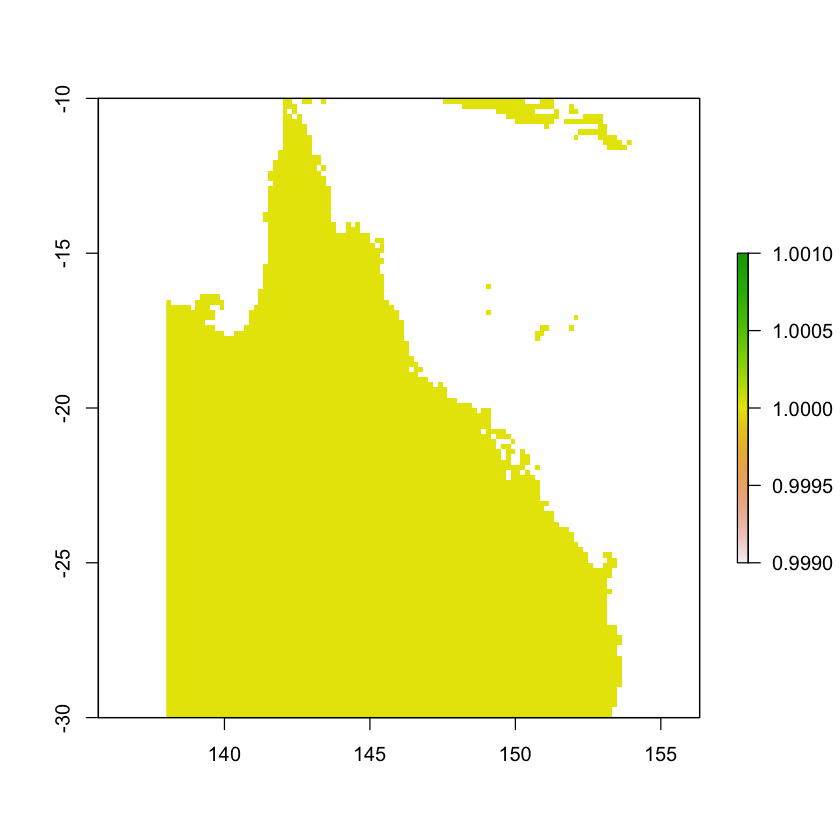

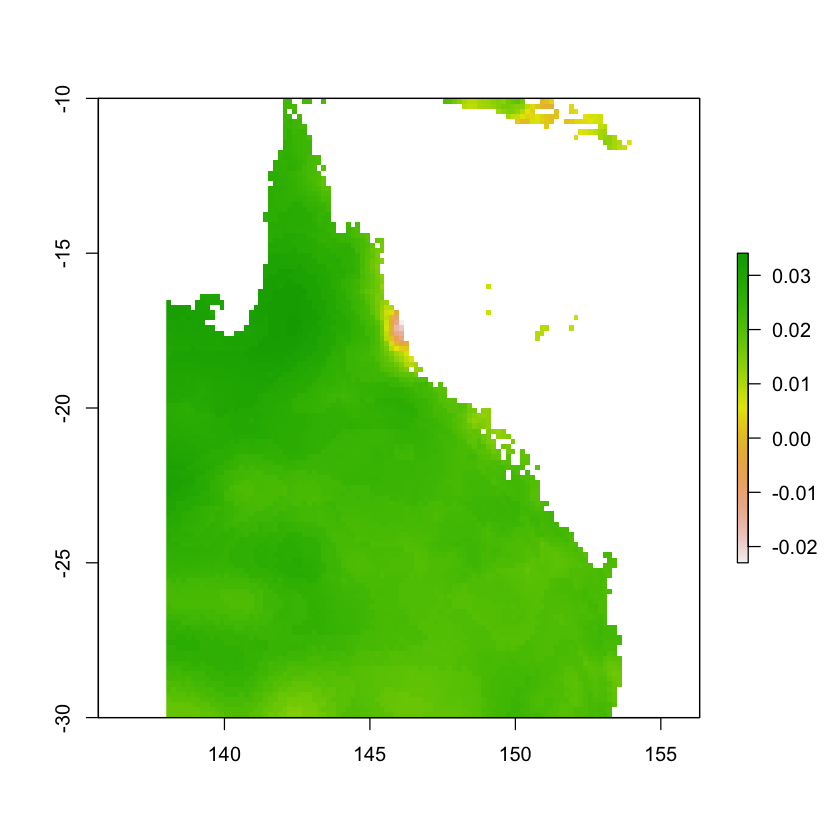

In [16]:
#future

forecasts = predict(env_data_forecast,
                    logistic_regr_model
                    ,type = "response")
extent_values <- extent(138, 154, -30, -10)
plot(predictions, ext = extent_values)
plot(forecasts > tr, ext = extent(138, 154, -30, -10))
plot(forecasts - predictions, ext = extent(138, 154, -30, -10))

